# 1. Imporation des librairies

In [2678]:
import pandas as pd
import plotly.figure_factory as ff
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats
from plotly.subplots import make_subplots
from math import ceil
import time
from scipy.stats import ks_2samp, bartlett,ttest_ind
from sklearn.preprocessing import LabelEncoder



from sklearn.decomposition import PCA

# 2. Importation du fichier final

In [2679]:
# chemin du dossier data_set
data_set_path = '~/project9/V2/dataset/'

# Lecture du data set nettoyé
final_df = pd.read_csv(data_set_path+'final_df.csv')

# final_df = final_df.drop(columns='langue courante')

Un aperçu du data set

In [2680]:
final_df.head()

,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante
0,Afghanistan,28.0,0.508772,5447.0,60.54,520.616409,Pashto
1,Afrique du Sud,1667.0,0.242682,8630.0,79.88,6121.876572,English
2,Albanie,13.0,0.808511,1550.0,70.08,4514.204908,Albanian
3,Algérie,275.0,0.007220,2003.0,57.17,4109.696001,Arabic
4,Allemagne,1514.0,0.484186,758.0,85.03,44651.829102,German


# 3. Matrice de corrélation entre les variable

/tmp/ipykernel_37074/3303323879.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



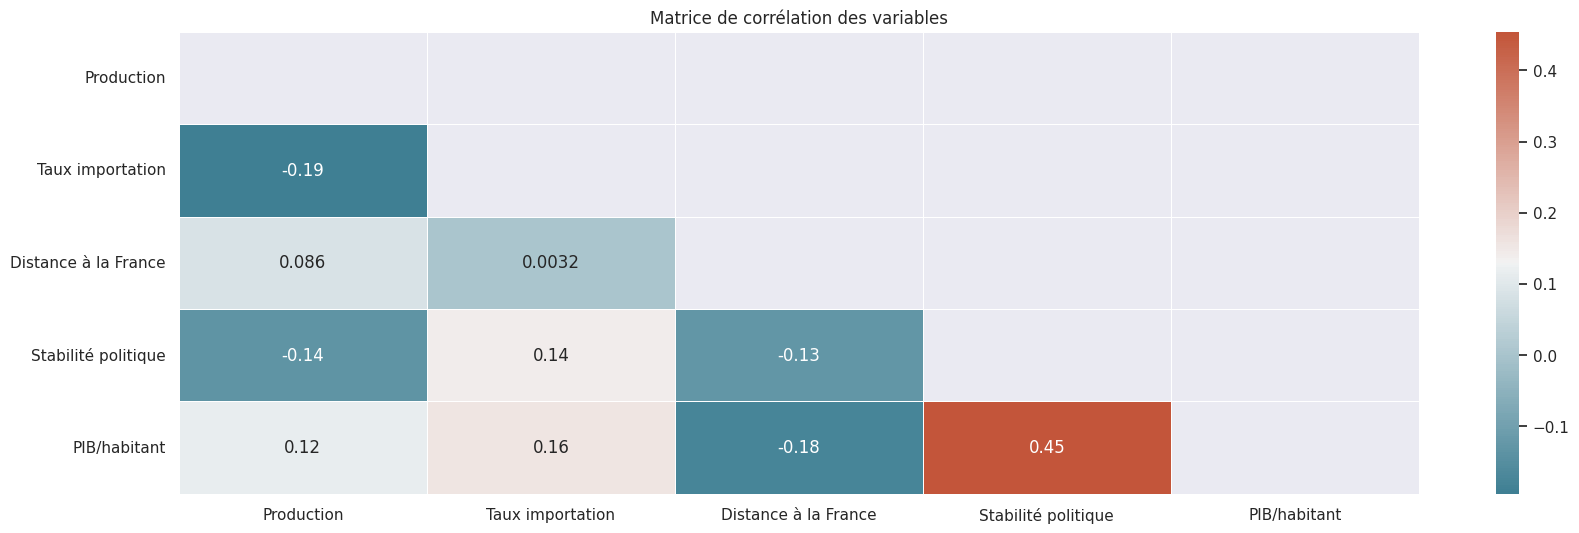

In [2681]:
# Création de la matrice de corrélation des variables

matrix = final_df.corr()

fig, ax = plt.subplots(figsize=(20, 6))
# Exclusion des valeurs en double et des valeurs en diagonales (retour faux) dans le but de ne pas les afficher dans notre heatmap option mask de la fonction heatmap sns
mask = np.triu(np.ones_like(matrix, dtype=bool))

#Création de la heatmap de corrélationb des variables


sns.heatmap(matrix,mask=mask,xticklabels=matrix.columns.values,
                 yticklabels=matrix.columns.values,cmap=sns.diverging_palette(220, 20, n=200),annot=True,linewidths=.5)
plt.title('Matrice de corrélation des variables')
plt.show()

# 3. Reformatage de la table principale 

Mise en index des pays

In [2682]:
final_df = final_df.set_index('Pays', drop=True, append=False, inplace=False, verify_integrity=False)
final_df.head()


,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante
Pays,,,,,,
Afghanistan,28.0,0.508772,5447.0,60.54,520.616409,Pashto
Afrique du Sud,1667.0,0.242682,8630.0,79.88,6121.876572,English
Albanie,13.0,0.808511,1550.0,70.08,4514.204908,Albanian
Algérie,275.0,0.007220,2003.0,57.17,4109.696001,Arabic
Allemagne,1514.0,0.484186,758.0,85.03,44651.829102,German


Variable X correpondant aux valeurs des variables

In [2683]:
X = final_df[['Production','Taux importation','Distance à la France','Stabilité politique','PIB/habitant']].values

# 
X[:2]


array([[2.80000000e+01, 5.08771930e-01, 5.44700000e+03, 6.05400000e+01,
        5.20616409e+02],
       [1.66700000e+03, 2.42681775e-01, 8.63000000e+03, 7.98800000e+01,
        6.12187657e+03]])

Dimensions de la matrice :

In [2684]:
X.shape

(169, 5)

Le nom des pays sont mis dans la variable country

In [2685]:
country =  final_df.index
country

Index(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie',
       ...
       'Ukraine', 'Uruguay', 'Vanuatu',
       'Venezuela (République bolivarienne du)', 'Viet Nam', 'Yémen', 'Zambie',
       'Zimbabwe', 'Djibouti', 'Maldives'],
      dtype='object', name='Pays', length=169)

Le nom des colonnes est enregistré dans la variable features

In [2686]:
features = final_df.columns
features

Index(['Production', 'Taux importation', 'Distance à la France',
       'Stabilité politique', 'PIB/habitant', 'langue courante'],
      dtype='object')

# 4. Centrage et réduction des données

Indexation des langues

In [2687]:
encoder = LabelEncoder()
X2 = final_df['langue courante'].values
X2_scaled = encoder.fit_transform(X2)
X2_scaled

array([51, 18,  0,  2, 24, 54, 18,  2, 63,  3, 18, 24,  4, 18,  6, 18,  5,
       17, 18, 22, 63,  8, 70, 54,  9, 22, 54, 35, 22, 18, 63, 11, 11, 46,
       46, 25, 63, 22, 63, 22, 13, 63, 15, 18,  2, 63,  2, 63, 63, 19, 65,
       18,  1, 56, 18, 21, 22, 18, 23, 18, 25, 18, 63, 22, 54, 18, 22, 63,
       28, 18, 27, 30, 52,  2, 31, 29, 26, 32, 18, 33,  2, 34, 64, 38, 18,
        2, 59, 39,  2, 18, 40, 41, 42, 43, 44, 12, 22, 45,  2, 18,  2, 63,
       47, 48, 54, 10, 18, 49, 63, 22, 18, 50, 22, 18,  2, 18, 74, 63, 63,
       17, 63, 20, 53, 22, 54, 22, 37, 55, 63, 37, 64, 55, 18, 36, 18, 18,
       18, 57, 54, 22, 58, 18, 61, 62,  2, 60, 66, 24, 17, 67,  2, 14, 69,
       68, 22, 18,  2, 72, 71, 73, 63,  7, 63, 75,  2, 18, 18,  2, 16])

Fusion des deux arrays

In [2688]:
x = 0
new_X = np.array(())
for element in X:
    element = np.insert(element,5,X2_scaled[x])
    new_X = np.append(new_X,element)
    x = x+1

new_X = np.reshape(new_X,(169,6))
new_X

array([[2.80000000e+01, 5.08771930e-01, 5.44700000e+03, 6.05400000e+01,
        5.20616409e+02, 5.10000000e+01],
       [1.66700000e+03, 2.42681775e-01, 8.63000000e+03, 7.98800000e+01,
        6.12187657e+03, 1.80000000e+01],
       [1.30000000e+01, 8.08510638e-01, 1.55000000e+03, 7.00800000e+01,
        4.51420491e+03, 0.00000000e+00],
       ...,
       [6.90000000e+01, 7.89473684e-02, 7.86300000e+03, 5.85600000e+01,
        1.54818637e+03, 1.80000000e+01],
       [7.25190476e+02, 1.00000000e+00, 5.43900000e+03, 2.94600000e+01,
        2.93069696e+03, 2.00000000e+00],
       [7.25190476e+02, 1.00000000e+00, 8.28800000e+03, 6.07000000e+01,
        9.57728937e+03, 1.60000000e+01]])

In [2689]:
scaler = StandardScaler()

# Mise à l'échelle des données par centrage réduction des données

scaled_X  = scaler.fit_transform(new_X)
scaled_X

array([[-2.78079678e-01,  9.63109224e-02, -1.50761605e-01,
        -4.12593693e-01, -6.99959809e-01,  8.32985680e-01],
       [ 3.81383652e-01, -4.16986730e-01,  6.67904864e-01,
         8.99942231e-01, -4.10135791e-01, -6.59324355e-01],
       [-2.84115035e-01,  6.74517867e-01, -1.15306862e+00,
         2.34851639e-01, -4.93320976e-01, -1.47331165e+00],
       ...,
       [-2.61583036e-01, -7.32836396e-01,  4.70632737e-01,
        -5.46969140e-01, -6.46790621e-01, -6.59324355e-01],
       [ 2.43987819e-03,  1.04390786e+00, -1.52819202e-01,
        -2.52188100e+00, -5.75255866e-01, -1.38286861e+00],
       [ 2.43987819e-03,  1.04390786e+00,  5.79942586e-01,
        -4.01735071e-01, -2.31343592e-01, -7.49767387e-01]])

En ayant centré réduit les données on s'attend à obtenir une moyenne de 0 (car centrage) et écart de type de 1 (car réduction) :

In [2690]:
# calcul des moyenne et écarts types pour chaque variables

idx = ["mean", "std"]   

pd.DataFrame(scaled_X).describe().round(2).loc[idx, :]


,0,1,2,3,4,5
mean,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


Les résultat obtenu sont corrects le centrage et réduction des données a réussi

# 7. Méthode PCA

Instanciation du module PCA

In [2691]:
pca=PCA(n_components=6)


Passage des données standardisé dans le modèle PCA.

In [2692]:
pca.fit(scaled_X)


PCA(n_components=6)

## 7.1 Définition du nombre de composantes, par le graphique de l'éblouis des valeurs propres (somme cumulées des variance expliquée) => Diagramme de Paretto

In [2693]:
# Calcul de la variance expliqué pour chaque composante

scree = (pca.explained_variance_ratio_*100).round(2)
display(scree)


# Calcul du critère de Kaiser 
kaiser_crietria = round(100/len(final_df.columns),2)


array([27.9 , 20.24, 16.98, 15.77, 11.46,  7.66])

In [2694]:
# Calcul de la somme cumulé des variances expliqués pour un nombre de cluster défini

scree_cum = scree.cumsum().round()
scree_cum

array([ 28.,  48.,  65.,  81.,  92., 100.])

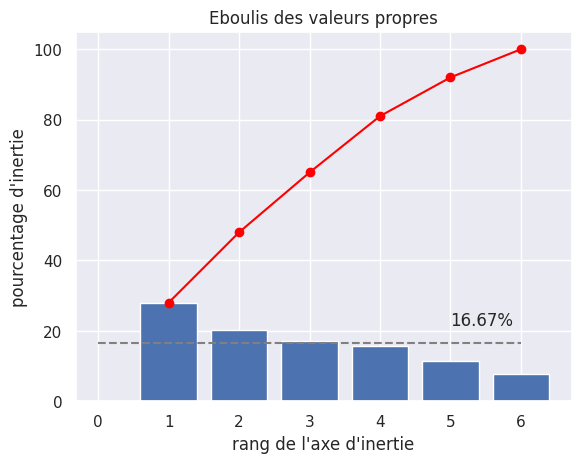

In [2695]:
# # Création du graphique de l'éblouis avec une ligne horizontale représentant le critère de kaiser 

x_list = range(1,len(final_df.columns)+1)
list(x_list)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.hlines(kaiser_crietria,0,len(final_df.columns),colors= 'grey',linestyles='dashed')
plt.text(len(final_df.columns)-1,kaiser_crietria+5, str(kaiser_crietria)+'%')
plt.show(block=False)


En bleu nous avons la variance expliquée de chaque composante et en rouge la somme cumulée de ces composantes
<br><br>
Les composante PC1 et PC2 et PC3 nous permettent de garder 65 % de l'information totale.
<br><br>
Le critère de Kaiser :On ne retient que les axes supérieurs au à l'inertie moyenne soit 100/6. Seul les trois premiers rangs ont une inertie supérieur à 16,67 %



## 7.2 Heatmap de corrélation des composantes et variables

In [2696]:
# Définition des compsantes principales par variables 

pcs = pca.components_

# Création d'un df des composantes princiaples

pcs = pd.DataFrame(pcs)

In [2697]:
# Définition des colonne et des index pour notre df des composantes princiaples et arrondis des composantes principales au centième

pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)


,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante
F1,-0.21,0.38,-0.34,0.56,0.55,-0.28
F2,0.61,-0.42,0.00,0.28,0.45,0.42
F3,-0.28,0.34,0.66,0.31,0.02,0.52
F4,0.56,0.42,0.47,-0.21,0.19,-0.46
F5,-0.22,-0.60,0.46,0.34,0.01,-0.51
F6,-0.38,-0.16,0.12,-0.59,0.68,0.07


On transpose loa table des composantes

In [2698]:
# Transposition du df
pcs = pcs.T

Chargement de `Seaborn`

In [2699]:
sns.set()

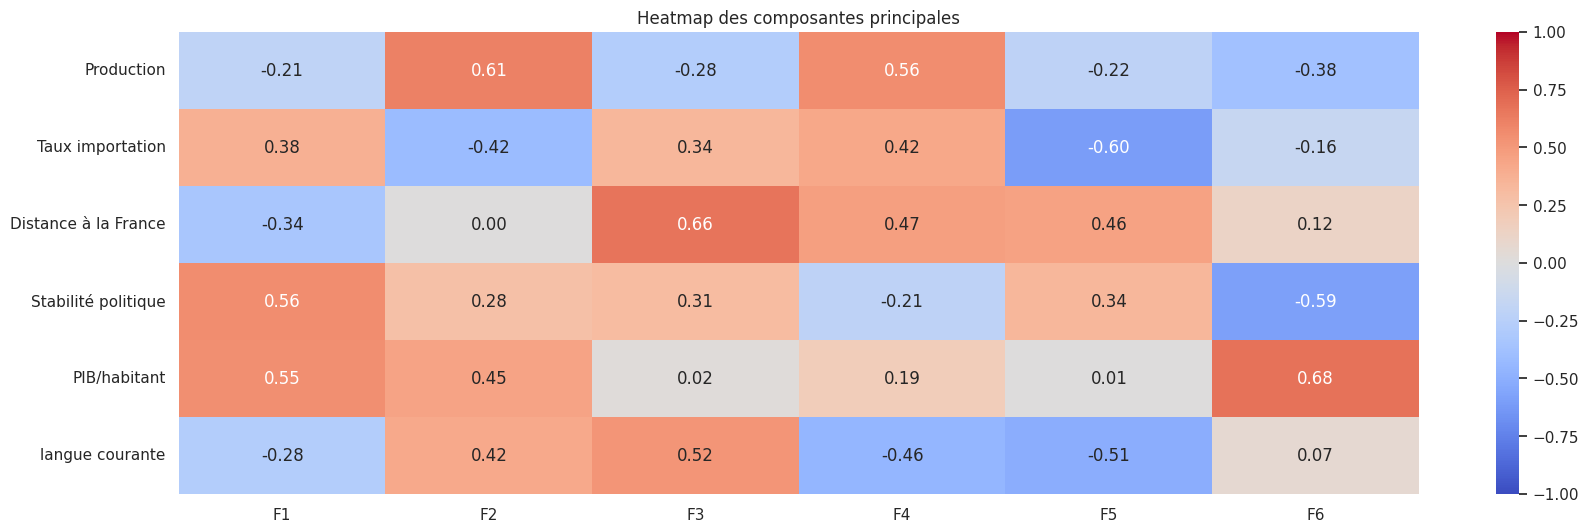

In [2700]:
# Création d'une heatmap des composantes principales
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title('Heatmap des composantes principales')

plt.show()

Dans le cadre de notre analyse nous ne prendrons que les composantes 1 et 2

# 8. Cercle des corrélations entre le composant 1 et 2

Dans le cadre de l’élaboration d’une méthode PCA le cercle de corrélation a pour but de définir la corrélation des variables avec les composantes principale étudié (la corrélation se fait de -1 à 1)

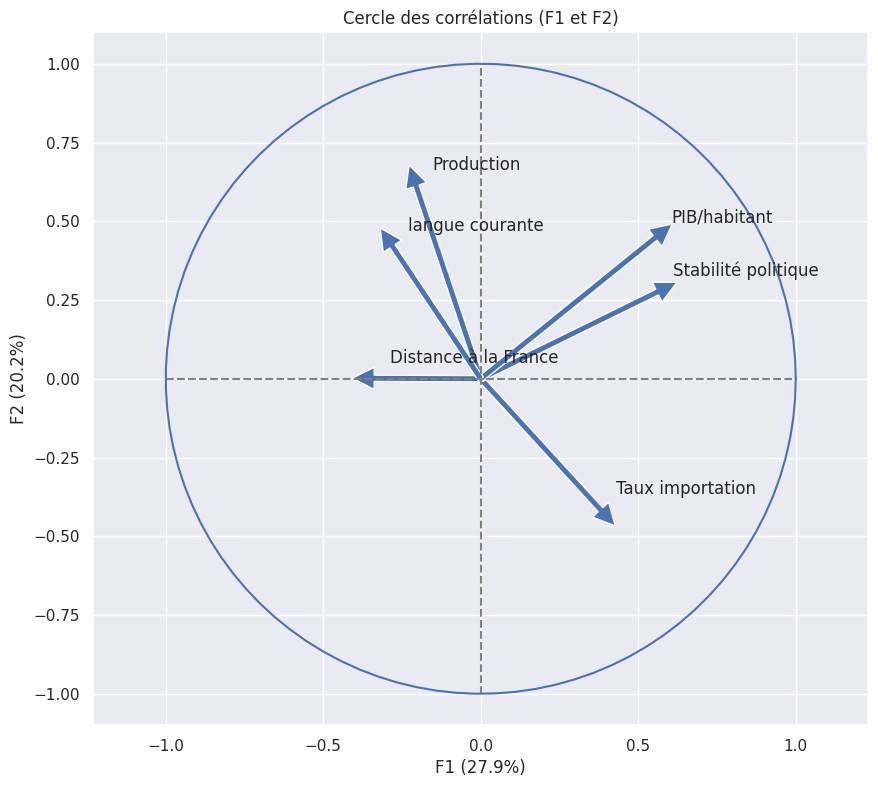

In [2701]:
x, y = 0,1

# Création du graphique des cercle de corrélation 
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Début de la flèche à l'origine du plan
             pca.components_[0, i],  #0 pour PC1
             pca.components_[1, i],  #1 pour PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

# Définition d'un array de 0 à 2*pi avec 100 valeurs (pour création du cercle (angle radians cercle trigonométrique))
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Création du cercle en utilisant pour x cos(angle radians => an) et y sin(angle radians => an=)
plt.axis('equal')
plt.show(block=False)

# 9. Détermination du nombre de cluster optimal pour 2 composants avec la méthode du coefficient de silhouette 

In [2702]:
# Détermination du nombre optimal de cluster à deux vu avec l'éblouis des valeurs propres

pca_graph=PCA(n_components= 2)
pca_graph.fit(scaled_X)
X_graph_proj = pca_graph.transform(scaled_X)


In [2703]:
#Création de la table de coefficient de sihouette

silhouette_tab = []


for i in range(2,15):
    kmeans = KMeans(n_clusters=i)
    cluster_labels = kmeans.fit_predict(X_graph_proj)
    silhouette_tab.append(silhouette_score(X_graph_proj,cluster_labels))

fig = px.line(silhouette_tab)

fig.update_layout(
    xaxis_title="Clusters", yaxis_title="Coefficient de silhouette moyen", title = 'Graphique des coefficients de silhouette', showlegend = False
)

fig.show()

Ici on constate que le nombre de cluster optimal en utilisant la méthode du coefficient de silhouette est de 10

# 10. Représentation graphique des clusters avec deux composants et centroids de classe

In [2704]:

columns_name = ['principal component 1','principal component 2']
# passage des pays en données de type series
country = pd.Series(data= country)


# Création d'un df pour les composantes priinciaples choisies
X_graph_proj = pd.DataFrame(data= X_graph_proj, columns= ['principal component 1','principal component 2'])

# MOdification du df final avec cluster en appliquant la méthode des composantes princiaples
cluster_final_df = pd.concat([X_graph_proj, country], axis = 1)



nb_cluster = 10

kmeans_1 = KMeans(n_clusters=nb_cluster)
predictions = kmeans_1.fit_predict(X_graph_proj)

# Création de la fonction qui rempli le df des centroids pour chaque cluster
def create_centroid_tab(kmeans,columns_n):
    centroid_tab_names = []
    for i in range(1,nb_cluster + 1):
        centroid_names = 'group centroid ' + str(i)
        centroids_coordinates = kmeans_1.cluster_centers_
        centroid_tab_names.append(centroid_names)
    columns_centroids = np.array(columns_n)
    centroid_tab = pd.DataFrame(columns= columns_centroids, data= centroids_coordinates)
    centroid_tab['Nom du centoid'] = centroid_tab_names
    return centroid_tab


centroid_tab = create_centroid_tab(kmeans_1,columns_name)

# Création du graphique qui affiche les composantes principale (cluster en couleur) et leur centroids (croix)
def draw_clusters_centroids(biased_dataset,centroid_tab, predictions,scree):

    clustered = pd.concat([biased_dataset, pd.DataFrame({'group':predictions+1})], axis=1)
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = centroid_tab['principal component 1'],
                        y = centroid_tab['principal component 2'],
                        mode= 'markers',
                        text = centroid_tab['Nom du centoid'],
                        marker_color = 'red',
                        ))
    fig.update_traces(
    marker=dict(size=15, symbol="cross", line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)

    fig.add_trace(go.Scatter(x = clustered['principal component 1'],
                                y = clustered['principal component 2'],
                                marker = dict(color = ["orange", "red", "green", "blue"]),
                                mode= 'markers',
                                marker_color = clustered['group'],
                                text ='Group :' + clustered['group'].astype(str)  +'<br>Pays : ' + clustered['Pays'],
                                ))
    fig.update_layout(showlegend = False,
                    title = 'Clustering avec deux composants principaux et centroids de classe',
                    title_font = dict(family ="Courier New, monospace",
                                        size = 18,
                                        color = 'black'),
                    xaxis_title='PC1('+str(scree[0])+' %)', yaxis_title='PC2('+str(scree[1])+' %)')

    fig.show()
    return clustered

cluster_final_df = draw_clusters_centroids(cluster_final_df,centroid_tab, predictions,scree)


# 11. Détermination du numéro de cluster choisi

Nous choisirons le cluster grâce à la composante principale 1. Pour choisir un pays où exporter le niveau de vie (PIB/habitant), la stabilité et la proximité sont importantes.

In [2705]:
# Définition du cluster choisi en fonction de la composante principale 1

chosen_cluster = cluster_final_df[cluster_final_df['principal component 1'] == max(cluster_final_df['principal component 1'])].group.values
print('Nous avons choisi le cluster '+str(chosen_cluster[0]))

Nous avons choisi le cluster 3


In [2706]:
country_group_df = cluster_final_df[['Pays','group']]

In [2707]:
final_df = final_df.reset_index()


# 12. Box plot des variables du cluster choisi

In [2708]:
# Ajout des numéro de group ou cluster à notre df final

final_df = pd.merge(final_df,country_group_df,how = 'outer', on = 'Pays')

In [2709]:
# Création du df final du cluster choisi

final_chosen_df = final_df[final_df.group == chosen_cluster[0]]

x = 1

# Création de boxplot des variables du cluster choisi
for i in range(1,nb_cluster+1):

    display_group_df = final_df[final_df.group == i]
    fig = make_subplots(rows=2, cols=int(len(features)/2),
    specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"}, {"type": "domain"}]],
    subplot_titles=features)

    fig.add_trace(go.Box(y = display_group_df[features[0]], hovertext = display_group_df['Pays'],name = features[0]), row= 1,col = 1)
    fig.add_trace(go.Box(y = display_group_df[features[1]], hovertext = display_group_df['Pays'],name = features[1]), row= 1,col = 2)
    fig.add_trace(go.Box(y = display_group_df[features[2]], hovertext = display_group_df['Pays'],name = features[2]), row= 1,col = 3)
    fig.add_trace(go.Box(y = display_group_df[features[3]], hovertext = display_group_df['Pays'],name = features[3]), row= 2,col = 1)
    fig.add_trace(go.Box(y = display_group_df[features[4]], hovertext = display_group_df['Pays'],name = features[4]), row= 2,col = 2)
    fig.add_trace(go.Pie(
     values=display_group_df['langue courante'].value_counts().values,
     labels=display_group_df['langue courante'].value_counts().index,
     domain=dict(x=[0.5, 1.0]),
     name=features[5]),
    row=2, col=3)
    fig.update_layout(title = 'Graphique décriptif du groupe ' +str(i))
    fig.show()
    display(display_group_df)
    print


,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
2,Albanie,13.000000,0.808511,1550.0,70.080000,4514.204908,Albanian,1
6,Antigua-et-Barbuda,0.000000,1.000000,6641.0,66.685032,15383.415191,English,1
9,Arménie,11.000000,0.744681,3516.0,69.620000,3914.525246,Armenian,1
13,Bahamas,6.000000,0.923077,7196.0,66.685032,32376.129780,English,1
19,Bénin,18.000000,0.763975,4059.0,69.680000,1136.593360,French,1
21,Bosnie-Herzégovine,61.000000,0.181818,1275.0,72.170000,5394.741461,Bosnian,1
24,Bulgarie,107.000000,0.687898,1848.0,64.990000,8335.277986,Bulgarian,1
26,Cabo Verde,1.000000,1.200000,4116.0,81.980000,3292.638358,Portuguese,1
37,Congo,7.000000,0.945455,5380.0,63.270000,2154.629048,French,1
40,Croatie,61.000000,0.533333,1053.0,70.410000,13439.243178,Croatian,1


,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
8,Argentine,2161.0,0.004077,11083.0,74.93,14648.845969,Spanish,2
20,Bolivie (État plurinational de),533.0,0.002331,9694.0,66.12,3351.127399,Spanish,2
22,Botswana,5.0,0.428571,7880.0,75.07,7893.362920,Tswana,2
30,Chili,712.0,0.230655,11185.0,79.47,14998.813979,Spanish,2
36,Colombie,1564.0,0.047474,8456.0,58.53,6376.707362,Spanish,2
45,El Salvador,136.0,0.122137,8976.0,72.76,3910.253179,Spanish,2
47,Équateur,340.0,0.000000,9360.0,66.36,6213.501276,Spanish,2
50,Eswatini,6.0,0.285714,8594.0,48.73,3913.145928,Swazi,2
53,Fédération de Russie,4444.0,0.049605,6108.0,50.55,10817.003315,Russian,2
62,Guatemala,235.0,0.361345,8945.0,60.67,4236.114906,Spanish,2


,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
4,Allemagne,1514.0,0.484186,758.0,85.030000,44651.829102,German,3
11,Autriche,148.0,0.635838,877.0,86.530000,47309.051637,German,3
32,Chine - RAS de Macao,3.0,1.210526,9784.0,66.685032,81043.968655,Cantonese,3
42,Danemark,173.0,0.796407,1243.0,89.640000,57938.797728,Danish,3
55,Finlande,129.0,0.144144,2488.0,91.080000,46385.550876,Finnish,3
74,Irlande,110.0,0.773438,1060.0,85.920000,70568.302444,Irish,3
75,Islande,10.0,0.200000,2436.0,86.970000,73949.769215,Icelandic,3
91,Luxembourg,0.0,1.000000,520.0,85.280000,111017.182246,Luxembourgish,3
111,Norvège,101.0,0.019608,1851.0,92.400000,75220.814442,Norwegian,3
119,Pays-Bas,1100.0,1.634409,772.0,88.720000,48989.638816,Dutch,3


,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
10,Australie,1269.0,0.013664,15246.0,83.98,57628.863849,English,4
29,Canada,1417.0,0.127006,6061.0,83.47,44906.748920,English,4
34,"Chine, Taiwan Province de",652.0,0.205096,10148.0,75.63,24283.464612,Mandarin,4
35,Chypre,25.0,0.368421,2868.0,80.21,19387.268663,Greek,4
38,Costa Rica,133.0,0.126866,8902.0,88.07,12225.577172,Spanish,4
48,Espagne,1515.0,0.136941,826.0,81.31,28137.441564,Spanish,4
68,Hongrie,493.0,0.218045,1379.0,70.99,14711.084220,Hungarian,4
76,Israël,629.0,0.000000,3233.0,68.99,43096.069697,Hebrew,4
77,Italie,1315.0,0.082694,929.0,73.74,32333.550863,Italian,4
79,Japon,2215.0,0.442650,9889.0,70.56,38672.407740,Japanese,4


,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
7,Arabie saoudite,616.000000,0.503136,4464.0,33.980000,20802.464299,Arabic,5
12,Azerbaïdjan,104.000000,0.209302,3684.0,43.600000,4150.868844,Azerbaijani,5
14,Bangladesh,249.000000,0.000000,7968.0,51.640000,1538.233627,Bengali,5
16,Bélarus,463.000000,0.079245,2018.0,47.570000,5790.908054,Belarusian,5
27,Cambodge,28.000000,0.263158,9947.0,57.930000,1385.260419,Khmer,5
28,Cameroun,81.000000,0.000000,4551.0,58.410000,1425.106072,French,5
44,Égypte,1118.000000,0.088000,3245.0,44.220000,2023.331158,Arabic,5
52,Éthiopie,14.000000,0.071429,5444.0,49.660000,721.753494,Amharic,5
54,Fidji,23.000000,0.115385,16835.0,71.360000,6101.130429,English,5
73,Iraq,96.000000,0.830389,3829.0,45.970000,4985.453728,Arabic,5


,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
51,États-Unis d'Amérique,21914.0,0.006734,7680.0,76.12,59921.674703,English,6


,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
0,Afghanistan,28.0,0.508772,5447.0,60.540000,520.616409,Pashto,7
1,Afrique du Sud,1667.0,0.242682,8630.0,79.880000,6121.876572,English,7
3,Algérie,275.0,0.007220,2003.0,57.170000,4109.696001,Arabic,7
5,Angola,42.0,0.868339,6712.0,59.580000,4095.811686,Portuguese,7
15,Barbade,15.0,0.117647,6772.0,66.685032,17419.313704,English,7
18,Belize,20.0,0.000000,8695.0,76.570000,4909.683055,English,7
25,Burkina Faso,46.0,0.000000,3689.0,76.150000,734.996282,French,7
39,Côte d'Ivoire,58.0,0.107692,4278.0,69.580000,2111.026809,French,7
64,Guinée-Bissau,3.0,1.000000,4107.0,69.910000,738.550286,Portuguese,7
65,Guyana,31.0,0.000000,7398.0,73.200000,6124.922066,English,7


,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
23,Brésil,14201.0,0.000301,8413.0,66.42,9928.675992,Portuguese,8
33,"Chine, continentale",18236.0,0.024888,8169.0,22.34,8663.126784,Mandarin,8


,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
17,Belgique,463.0,2.223684,557.0,87.25,44025.903247,Dutch,9
31,Chine - RAS de Hong-Kong,24.0,3.239286,9818.0,70.54,46705.027813,Cantonese,9


,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
41,Cuba,29.0,0.912281,7705.0,28.25,8541.214440,Spanish,10
129,République populaire démocratique de Corée,43.0,0.000000,9002.0,15.02,682.848778,Korean,10
157,Turkménistan,20.0,0.333333,4658.0,15.81,6752.362494,Turkmen,10
163,Viet Nam,918.0,0.241294,9773.0,26.04,2365.521494,Vietnamese,10


Nous avons ici affaire avec des petits états (la plupart du temps des îles) qui consomme énormément de volaille et sont assez dépendante des importations.

Selon toute vraisemblance, il serait judicieux de commencer l'exportation de volaile à Hong-Kong. En effet ce pays, a un niveau de vie élevé et une forte consommation de volaille, sans en produire lui-même.

# 12. Représentation des valeurs initiale du cluster choisi sous-forme d'histogramme

Histogramme des variables

Histogramme de Production
skw:
 2.134310890363801
kur:
 3.557902265142501


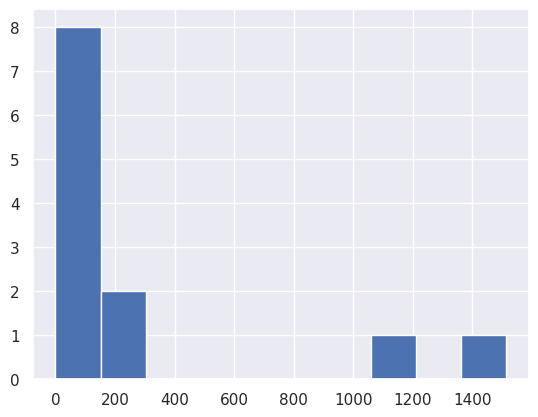

Histogramme de Taux importation
skw:
 0.7503460516337089
kur:
 0.2732471601744155


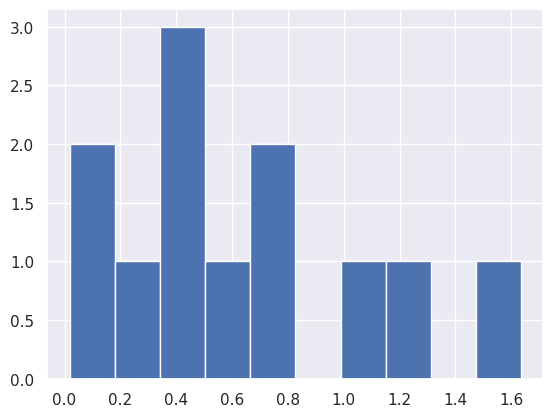

Histogramme de Distance à la France
skw:
 3.0030616091232805
kur:
 9.662103261051929


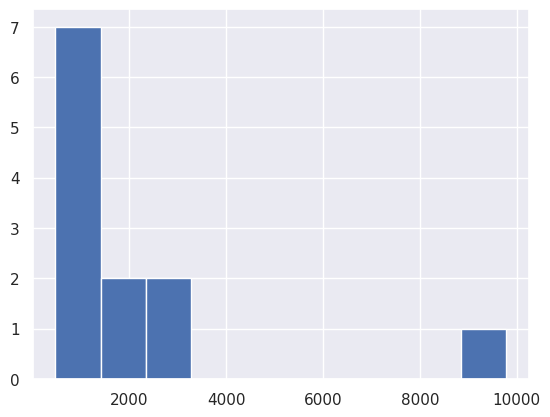

Histogramme de Stabilité politique
skw:
 -2.6171594512101426
kur:
 8.051976920114928


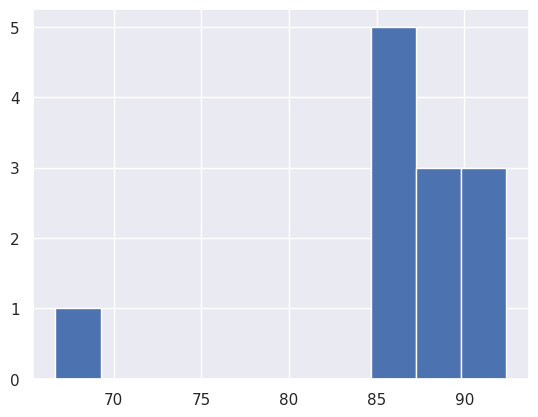

Histogramme de PIB/habitant
skw:
 0.9177154444177056
kur:
 0.6790071313599872


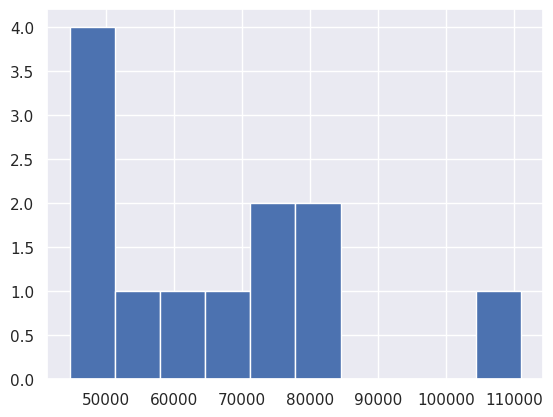

In [2710]:
# Histogramme des variable du cluster choisi
features = ['Production','Taux importation','Distance à la France','Stabilité politique','PIB/habitant']
for i in features:
    print('Histogramme de ' + i )
    final_chosen_df[i].hist()
    print("skw:\n",final_chosen_df[i].skew())
    print("kur:\n",final_chosen_df[i].kurtosis())
    plt.show()

# 13. Test d'adéquation à une distribution gaussienne et test ANOVA entre deux clusters en fonction de le corrélation en terme de comosante princiaples
Avec H0 : l'échantillon suit une distribution de type Gaussienne <br>
Avec H1 : l'écantillon ne suit pas une distribution de type Gaussienne <br>
Si H0 du test d'adéquation ne peur être rejeté alors élaboration d'un test de comparaison (d'égalité des variance) de type barlett et affichage de la p value du test d'adéquation <br>
La comparaison se fait avec le group 4 qui suit la même tendance sur la composante principales 1 <br>
Avec H0 : Il y a égalité des variances entre les échantillons <br>
Avec H1 : Il y a égalité des variances entre les échantillons <br>
On affiche la pvalue du test barlett et si pvalue < 0.05 test de comparaison des moyenness ttest_ind <br>
Avec H0 : Il y a égalité des moyennes entre les échantillons <br>
Avec H1 : Il y a égalité des moyennes entre les échantillons <br>
On affiche la pvalue du test de comparaison des moyennes et infirme ou valide H0 <br>

In [2711]:
# Incrémentation des tests statistiques
comp_group_df = final_df[final_df['group'] == 3]

display(comp_group_df.head())
for i in features:
    print('Pour '+ i +' : \n')
    Data_pays_clusters_C1 = final_df.loc[(final_df["group"] == chosen_cluster[0]),i]
    Data_pays_clusters_C3 = final_df.loc[(final_df["group"] == 5),i] # Attention changer le nombre après chargement complet prendre le groupe dont la coordonnée x dans le scatter plot (PC1 ou F1) se rapproche le plus de notre centroid choisi.

    stat , p = stats.ks_2samp(final_chosen_df[i],list(np.random.normal(np.mean(final_chosen_df[i]), np.std(final_chosen_df[i]), 1000)))
    if p>=0.05:
        print(str(round(p,2)) + " est supérieur à 0.05. L'hypothèse H0 n'est ainsi pas rejetée.\nLa population du cluster suit une distribution Gaussienne.\n")
        stat_1, p_1 = bartlett(Data_pays_clusters_C1,Data_pays_clusters_C3)
        if p_1>=0.05:
            print(str(round(p_1,2)) + " est supérieur à 0.05. L'hypothèse H0 n'est ainsi pas rejetée.\nLes variances des deux clusters sont égales.\n")
            stat_2, p_2 =  ttest_ind(Data_pays_clusters_C1,Data_pays_clusters_C3, equal_var=False)
            if p_2>=0.05:
                print(str(round(p_2,2)) + " est supérieur à 0.05. L'hypothèse H0 n'est pas rejetée.\nLes moyennes des deux clusters sont égales.")
            else:print(str(round(p_2,2)) + " est inférieur à 0.05. L'hypothèse H0 est ainsi rejetée.\nLes moyennes des deux clusters ne sont pas égales.")
        else:print(str(round(p_1,2)) + " est inférieur à 0.05. L'hypothèse H0 est ainsi rejetée.\nLes variances des deux clusters ne sont pas égales.")
    else:print(str(round(p,2)) + " est inférieur à 0.05. L'hypothèse H0 est ainsi rejetée.\nLa population du cluster ne suit pas une distribution de type Gaussiennne.")

    print('\n')

,Pays,Production,Taux importation,Distance à la France,Stabilité politique,PIB/habitant,langue courante,group
4,Allemagne,1514.0,0.484186,758.0,85.030000,44651.829102,German,3
11,Autriche,148.0,0.635838,877.0,86.530000,47309.051637,German,3
32,Chine - RAS de Macao,3.0,1.210526,9784.0,66.685032,81043.968655,Cantonese,3
42,Danemark,173.0,0.796407,1243.0,89.640000,57938.797728,Danish,3
55,Finlande,129.0,0.144144,2488.0,91.080000,46385.550876,Finnish,3


Pour Production : 

0.02 est inférieur à 0.05. L'hypothèse H0 est ainsi rejetée.
La population du cluster ne suit pas une distribution de type Gaussiennne.


Pour Taux importation : 

0.95 est supérieur à 0.05. L'hypothèse H0 n'est ainsi pas rejetée.
La population du cluster suit une distribution Gaussienne.

0.7 est supérieur à 0.05. L'hypothèse H0 n'est ainsi pas rejetée.
Les variances des deux clusters sont égales.

0.16 est supérieur à 0.05. L'hypothèse H0 n'est pas rejetée.
Les moyennes des deux clusters sont égales.


Pour Distance à la France : 

0.1 est supérieur à 0.05. L'hypothèse H0 n'est ainsi pas rejetée.
La population du cluster suit une distribution Gaussienne.

0.07 est supérieur à 0.05. L'hypothèse H0 n'est ainsi pas rejetée.
Les variances des deux clusters sont égales.

0.0 est inférieur à 0.05. L'hypothèse H0 est ainsi rejetée.
Les moyennes des deux clusters ne sont pas égales.


Pour Stabilité politique : 

0.18 est supérieur à 0.05. L'hypothèse H0 n'est ainsi pas r